<div align="right">Student Name: <b>Vishal Beniwal</b><br>Student Number: <b>s3759790</b><br>Subject Code: <b>COSC2673/2973</b></div>

# Computational Machine Learning Assignment 2
## Project 1: Classify Images of Road Traffic Signs

<h3>Task 1: Classify images according to sign-shape</h3>

This Notebook will take you through the steps followed to build a model to predict the traffic sign shapes in a 28 by 28 pixel images.

In [1]:
#Importing the required libraries
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

/home/ec2-user/SageMaker/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/SageMaker/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/SageMaker/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-user/SageMaker/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future 

## Load & Prepare The Dataset

This section of the notebook will deal with loading the traffic sign dataset. The dataset was uploaded into the notebook work environment and unzipped using the following code.

In [2]:
#Unzipping the upload zip folder
import zipfile
with zipfile.ZipFile('./trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

Following code iterate through the sub folders and read all the image names and sub folder names to create a data frame with relevant information that can be used for training and testing the model

In [3]:
from PIL import Image
import glob

image_list = []
for filepath in glob.glob('trafficsigns_dataset/*/*/*.png', recursive=True):
   
    filename = filepath.split("/")[-1]
    label = filepath.split("/")[2]
    shape_label = filepath.split("/")[1]
    image_list.append((filepath, shape_label, label))
                      
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path','shape_label', 'label'])

To check the loaded images, following code will pick and plot 4 random images from the datatset

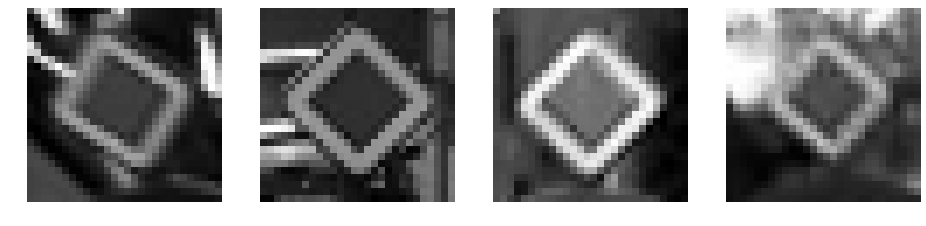

In [4]:
random_index = np.random.choice(100, 4)
rand_data = data.loc[random_index,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [5]:
#Checking the shape labels
data['shape_label'].unique()

array(['hex', 'diamond', 'round', 'triangle', 'square'], dtype=object)

In [6]:
#Checking the shape of loaded dataset
data.shape

(3699, 3)

In [7]:
#Checking few top most records of the dataset
data.head()

,image_path,shape_label,label
0,trafficsigns_dataset/hex/stop/01920_00000.png,hex,stop
1,trafficsigns_dataset/hex/stop/00684_00000.png,hex,stop
2,trafficsigns_dataset/hex/stop/00375_00002.png,hex,stop
3,trafficsigns_dataset/hex/stop/01832_00001.png,hex,stop
4,trafficsigns_dataset/hex/stop/01258_00001.png,hex,stop


In [8]:
# Shuffled the dataset
from sklearn.utils import shuffle
data = shuffle(data)

In [9]:
# Validating the shuffle operation
data.head()

,image_path,shape_label,label
1644,trafficsigns_dataset/round/noparking/00863_000...,round,noparking
3079,trafficsigns_dataset/square/continue/01482_000...,square,continue
716,trafficsigns_dataset/round/bicycle/01963_00000...,round,bicycle
683,trafficsigns_dataset/round/noentry/01014_00000...,round,noentry
2713,trafficsigns_dataset/triangle/warning/00327_00...,triangle,warning


Checking the sample count for each shape label

In [10]:
print ("records with diamond shape is " , len(data[data['shape_label']=='diamond']))
print ("records with hex shape is " , len(data[data['shape_label']=='hex']))
print ("records with round shape is " , len(data[data['shape_label']=='round']))
print ("records with square shape is ",len(data[data['shape_label']=='square']))
print ("records with triange shape is ", len(data[data['shape_label']=='triangle']))

records with diamond shape is  282
records with hex shape is  43
records with round shape is  1760
records with square shape is  688
records with triange shape is  926


As this notebook is dealing with classifying shape of a traffic sign, Therefore, a filtered version of original data was used for further processing

In [11]:
shape_data = data[['image_path','shape_label']]

## Training, Validation and Testing Dataset

The following code is using sklearn library to perform hold-out cross validation and split the dataset into 3 subsets

In [12]:
from sklearn.model_selection import train_test_split

train_shapes, test_shapes = train_test_split(shape_data,test_size = 0.2)
training_data, validation_data = train_test_split(train_shapes,test_size = 0.2)

In [13]:
training_data.shape

(2367, 2)

In [14]:
validation_data.shape

(592, 2)

In [15]:
test_shapes.shape

(740, 2)

Checking the sample count for each shape label in testing dataset

In [16]:
print ("records with diamond shape is " , len(test_shapes[test_shapes['shape_label']=='diamond']))
print ("records with hex shape is " , len(test_shapes[test_shapes['shape_label']=='hex']))
print ("records with round shape is " , len(test_shapes[test_shapes['shape_label']=='round']))
print ("records with square shape is ",len(test_shapes[test_shapes['shape_label']=='square']))
print ("records with triange shape is ", len(test_shapes[test_shapes['shape_label']=='triangle']))

records with diamond shape is  51
records with hex shape is  8
records with round shape is  375
records with square shape is  111
records with triange shape is  195


Mapping the labels to numeric values in testing dataset for later use

In [17]:
newlabels = {'diamond':0, 'hex':1, 'round':2, 'square':3,'triangle':4}
test_shapes['shape_label_num'] = test_shapes['shape_label'].map(newlabels,na_action='ignore')

In [18]:
#Validating the mapping
test_shapes.head()

,image_path,shape_label,shape_label_num
3129,trafficsigns_dataset/square/continue/01623_000...,square,3
203,trafficsigns_dataset/diamond/rightofway/01111_...,diamond,0
3471,trafficsigns_dataset/square/parking/00175_0000...,square,3
2055,trafficsigns_dataset/round/traveldirection/005...,round,2
755,trafficsigns_dataset/round/bicycle/00759_00001...,round,2


## Functions For Model Evaluation & Plotting Results

The following sections define three functions.

1. The First function calculates and returns the average accuracy and the loss for a given image stream.
2. The Seconf function is used to calculate the accuracy and losses of a trained model
3. The Third function is used to plot the results gained after modelling.

In [19]:
def calculate_losses(model_, data_generator_, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    for x,y in data_generator_:
        loss,acc = model_.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
    return np.mean(loss_hold), np.mean(acc_hold)

In [20]:
def train_model(model_, num_epoch=100, verbose=1):
    res = []
    for e in range(num_epoch):
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [21]:
def plot_results(res):
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

## Model Training & Evaluation

The next block of code:

1. Will defind the data generator for each subset which will be used to stream the data into model in a specified batch size.
2. Rescale the images to normalize them
3. Define the batch size

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=training_data,
    directory='./',
    x_col="image_path",
    y_col="shape_label",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_data,
    directory='./',
    x_col="image_path",
    y_col="shape_label",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_shapes,
    directory='./',
    x_col="image_path",
    y_col="shape_label",
    target_size=(28, 28),
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical')

Found 2367 validated image filenames belonging to 5 classes.
Found 592 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [23]:
# Defining variables with train and validation sample size for later use
N_train_images = 2367
N_val_images =592

## Multi-Layer Perceptron Model

Simple MLP model with 2 Hidden layers

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________

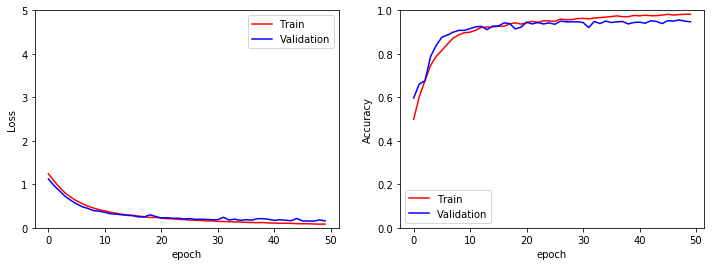

In [24]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, Lambda
from tensorflow.keras import regularizers, optimizers
# Input layer
input_ = Input(shape=(28, 28, 3))

input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)

x = Flatten()(input_slice) # This will convert the 28x28 input to a vector of dimension 784

# First Hidden layer
h = Dense(64)(x)
h = Activation('relu')(h)

# Second Hidden layer
h2 = Dense(64)(h)
h2 = Activation('relu')(h2)

# Output layer
out_ = Dense(5)(h2)
out_ = Activation('softmax')(out_)
MLP = Model(inputs=input_, outputs=out_) # Setup the model

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
MLP.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

MLP.summary()

res = train_model(MLP, num_epoch=50, verbose=1)

plot_results(res)

# Convolutional Neural Network Model

## model_cnn_2L

Simple CNN Model with 2 Hidden Layers


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
activation_3 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_4 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0

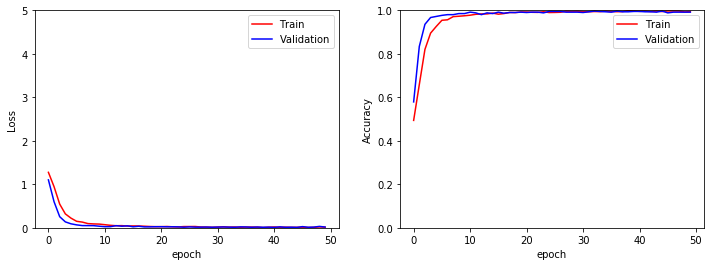

In [25]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_cnn_2L = Sequential()

# input
model_cnn_2L.add(Input(shape=(28, 28, 3)))

model_cnn_2L.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model_cnn_2L.add(Conv2D(32, (3, 3)))
model_cnn_2L.add(Activation('relu'))
model_cnn_2L.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
model_cnn_2L.add(Conv2D(32, (3, 3)))
model_cnn_2L.add(Activation('relu'))
model_cnn_2L.add(MaxPooling2D(pool_size=(2, 2)))


# MLP
model_cnn_2L.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn_2L.add(Dense(64))
model_cnn_2L.add(Activation('relu'))
model_cnn_2L.add(Dropout(0.5))
model_cnn_2L.add(Dense(5))
model_cnn_2L.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn_2L.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn_2L.summary()
                 
# model_cnn_2L.save('model.h5')
                         
res = train_model(model_cnn_2L, num_epoch=50, verbose=1)

plot_results(res)

## model_cnn_3L
CNN Model with 3 Hidden Layers 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_7 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)         

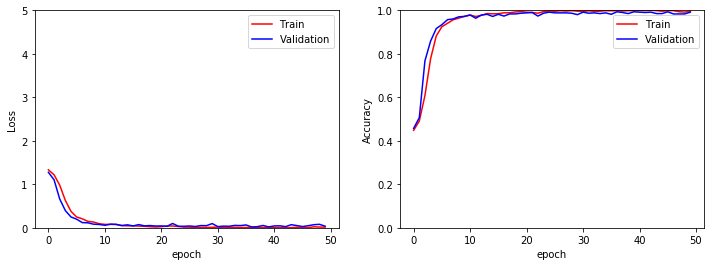

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_cnn_3L = Sequential()

# input
model_cnn_3L.add(Input(shape=(28, 28, 3)))

model_cnn_3L.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model_cnn_3L.add(Conv2D(32, (3, 3)))
model_cnn_3L.add(Activation('relu'))
model_cnn_3L.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
model_cnn_3L.add(Conv2D(32, (3, 3)))
model_cnn_3L.add(Activation('relu'))
model_cnn_3L.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 3
model_cnn_3L.add(Conv2D(64, (3, 3)))
model_cnn_3L.add(Activation('relu'))
model_cnn_3L.add(MaxPooling2D(pool_size=(2, 2)))

# MLP
model_cnn_3L.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn_3L.add(Dense(64))
model_cnn_3L.add(Activation('relu'))
model_cnn_3L.add(Dropout(0.5))
model_cnn_3L.add(Dense(5))
model_cnn_3L.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn_3L.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn_3L.summary()

res = train_model(model_cnn_3L, num_epoch=50, verbose=1)

plot_results(res)

## Tuned model_cnn_2L : model_cnn_2L_v2

This is the tuned version of cnn model with 2 hidden layers but without Dropout Layer

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_12 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 32)         

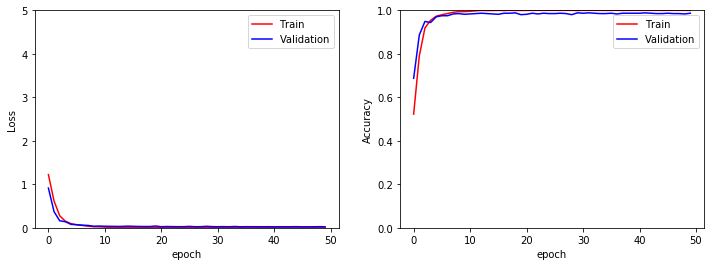

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_cnn_2L_v2 = Sequential()

# input
model_cnn_2L_v2.add(Input(shape=(28, 28, 3)))

model_cnn_2L_v2.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model_cnn_2L_v2.add(Conv2D(32, (3, 3)))
model_cnn_2L_v2.add(Activation('relu'))
model_cnn_2L_v2.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
model_cnn_2L_v2.add(Conv2D(32, (3, 3)))
model_cnn_2L_v2.add(Activation('relu'))
model_cnn_2L_v2.add(MaxPooling2D(pool_size=(2, 2)))


# MLP
model_cnn_2L_v2.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn_2L_v2.add(Dense(64))
model_cnn_2L_v2.add(Activation('relu'))
model_cnn_2L_v2.add(Dense(5))
model_cnn_2L_v2.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn_2L_v2.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn_2L_v2.summary()
                 
                         
res = train_model(model_cnn_2L_v2, num_epoch=50, verbose=1)

plot_results(res)

## Tuned model_cnn_2L: model_cnn_2L_v3

The orginal model "model_cnn_2L" with Adam Optimizer

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_16 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_17 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 32)         

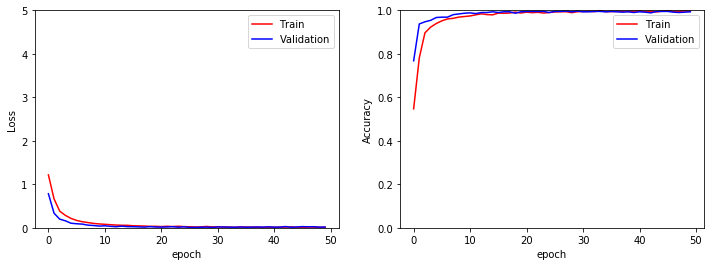

In [28]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_cnn_2L_v3 = Sequential()

# input
model_cnn_2L_v3.add(Input(shape=(28, 28, 3)))

model_cnn_2L_v3.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model_cnn_2L_v3.add(Conv2D(32, (3, 3)))
model_cnn_2L_v3.add(Activation('relu'))
model_cnn_2L_v3.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
model_cnn_2L_v3.add(Conv2D(32, (3, 3)))
model_cnn_2L_v3.add(Activation('relu'))
model_cnn_2L_v3.add(MaxPooling2D(pool_size=(2, 2)))


# MLP
model_cnn_2L_v3.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn_2L_v3.add(Dense(64))
model_cnn_2L_v3.add(Activation('relu'))
model_cnn_2L_v3.add(Dropout(0.5))
model_cnn_2L_v3.add(Dense(5))
model_cnn_2L_v3.add(Activation('softmax'))

model_cnn_2L_v3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

model_cnn_2L_v3.summary()
                 
# model_cnn_2L.save('model.h5')
                         
res = train_model(model_cnn_2L_v3, num_epoch=50, verbose=1)

plot_results(res)

## Tuned model_cnn_3L: model_cnn_3L_v2

To improve the performance of previous 3 layer model we added L2 regularlization technique

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_20 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_21 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 32)         

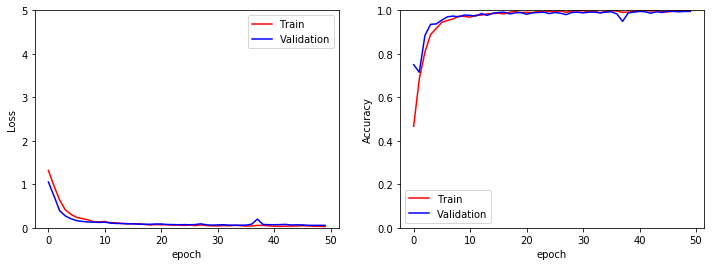

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_cnn_3L_v2 = Sequential()

# input
model_cnn_3L_v2.add(Input(shape=(28, 28, 3)))

model_cnn_3L_v2.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model_cnn_3L_v2.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn_3L_v2.add(Activation('relu'))
model_cnn_3L_v2.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
model_cnn_3L_v2.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn_3L_v2.add(Activation('relu'))
model_cnn_3L_v2.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 3
model_cnn_3L_v2.add(Conv2D(64, (3, 3)))
model_cnn_3L_v2.add(Activation('relu'))
model_cnn_3L_v2.add(MaxPooling2D(pool_size=(2, 2)))

# MLP
model_cnn_3L_v2.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn_3L_v2.add(Dense(64))
model_cnn_3L_v2.add(Activation('relu'))
model_cnn_3L_v2.add(Dropout(0.5))
model_cnn_3L_v2.add(Dense(5))
model_cnn_3L_v2.add(Activation('softmax'))

model_cnn_3L_v2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

model_cnn_3L_v2.summary()

res = train_model(model_cnn_3L_v2, num_epoch=50, verbose=1)

plot_results(res)

## Tuned model_cnn_3L: model_cnn_L1_reg

To improve the performance of previous 3 layer model we added L1 regularlization technique

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_25 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_26 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 32)         

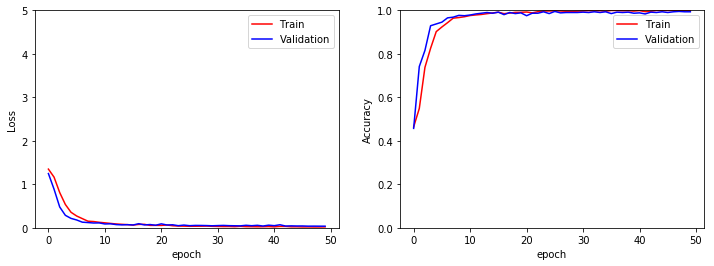

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_cnn_l1_reg = Sequential()

# input
model_cnn_l1_reg.add(Input(shape=(28, 28, 3)))

model_cnn_l1_reg.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model_cnn_l1_reg.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l1(0.001)))
model_cnn_l1_reg.add(Activation('relu'))
model_cnn_l1_reg.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
model_cnn_l1_reg.add(Conv2D(32, (3, 3)))
model_cnn_l1_reg.add(Activation('relu'))
model_cnn_l1_reg.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 3
model_cnn_l1_reg.add(Conv2D(64, (3, 3)))
model_cnn_l1_reg.add(Activation('relu'))
model_cnn_l1_reg.add(MaxPooling2D(pool_size=(2, 2)))

# MLP
model_cnn_l1_reg.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn_l1_reg.add(Dense(64))
model_cnn_l1_reg.add(Activation('relu'))
model_cnn_l1_reg.add(Dropout(0.5))
model_cnn_l1_reg.add(Dense(5))
model_cnn_l1_reg.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn_l1_reg.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


model_cnn_l1_reg.summary()

res = train_model(model_cnn_l1_reg, num_epoch=50, verbose=1)

plot_results(res)

# Predictions

## Prediction using model_cnn_2L

In [31]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

predictions = model_cnn_2L.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
cm = confusion_matrix(true_classes, predictedLabels)
print(cm)

Prediction shape is (740, 5)
              precision    recall  f1-score   support

     diamond       1.00      0.94      0.97        51
         hex       1.00      0.88      0.93         8
       round       0.99      1.00      1.00       375
      square       0.99      0.99      0.99       111
    triangle       0.99      0.99      0.99       195

   micro avg       0.99      0.99      0.99       740
   macro avg       0.99      0.96      0.98       740
weighted avg       0.99      0.99      0.99       740

[[ 48   0   2   0   1]
 [  0   7   1   0   0]
 [  0   0 375   0   0]
 [  0   0   0 110   1]
 [  0   0   0   1 194]]


## Prediction using model_cnn_3L

In [32]:
from sklearn import metrics

predictions = model_cnn_3L.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
cm = confusion_matrix(true_classes, predictedLabels)
print(cm)

Prediction shape is (740, 5)
              precision    recall  f1-score   support

     diamond       1.00      0.92      0.96        51
         hex       1.00      0.88      0.93         8
       round       0.99      0.99      0.99       375
      square       0.97      0.99      0.98       111
    triangle       0.98      0.99      0.99       195

   micro avg       0.99      0.99      0.99       740
   macro avg       0.99      0.95      0.97       740
weighted avg       0.99      0.99      0.99       740

[[ 47   0   2   0   2]
 [  0   7   1   0   0]
 [  0   0 372   2   1]
 [  0   0   0 110   1]
 [  0   0   0   1 194]]


## Prediction using model_cnn_2L_v2

In [33]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

predictions = model_cnn_2L_v2.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
cm = confusion_matrix(true_classes, predictedLabels)
print(cm)

Prediction shape is (740, 5)
              precision    recall  f1-score   support

     diamond       0.94      1.00      0.97        51
         hex       1.00      0.88      0.93         8
       round       0.99      0.99      0.99       375
      square       0.98      0.98      0.98       111
    triangle       0.98      0.98      0.98       195

   micro avg       0.99      0.99      0.99       740
   macro avg       0.98      0.97      0.97       740
weighted avg       0.99      0.99      0.99       740

[[ 51   0   0   0   0]
 [  0   7   1   0   0]
 [  2   0 370   1   2]
 [  0   0   0 109   2]
 [  1   0   1   1 192]]


## Prediction using model_cnn_3L_v2

In [34]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

predictions = model_cnn_3L_v2.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
cm = confusion_matrix(true_classes, predictedLabels)
print(cm)

Prediction shape is (740, 5)
              precision    recall  f1-score   support

     diamond       1.00      1.00      1.00        51
         hex       1.00      1.00      1.00         8
       round       1.00      1.00      1.00       375
      square       0.96      0.99      0.98       111
    triangle       0.99      0.98      0.99       195

   micro avg       0.99      0.99      0.99       740
   macro avg       0.99      0.99      0.99       740
weighted avg       0.99      0.99      0.99       740

[[ 51   0   0   0   0]
 [  0   8   0   0   0]
 [  0   0 374   1   0]
 [  0   0   0 110   1]
 [  0   0   1   3 191]]


## Prediction using model_cnn_l1_reg

In [35]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

predictions = model_cnn_l1_reg.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
cm = confusion_matrix(true_classes, predictedLabels)
print(cm)

Prediction shape is (740, 5)
              precision    recall  f1-score   support

     diamond       1.00      1.00      1.00        51
         hex       1.00      1.00      1.00         8
       round       1.00      1.00      1.00       375
      square       0.98      0.99      0.99       111
    triangle       0.99      0.99      0.99       195

   micro avg       1.00      1.00      1.00       740
   macro avg       1.00      1.00      1.00       740
weighted avg       1.00      1.00      1.00       740

[[ 51   0   0   0   0]
 [  0   8   0   0   0]
 [  0   0 374   1   0]
 [  0   0   0 110   1]
 [  0   0   0   1 194]]


## Prediction using MLP model

In [36]:
from sklearn import metrics

predictions = MLP.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
cm = confusion_matrix(true_classes, predictedLabels)
print(cm)

Prediction shape is (740, 5)
              precision    recall  f1-score   support

     diamond       0.85      0.88      0.87        51
         hex       1.00      0.62      0.77         8
       round       0.94      0.97      0.96       375
      square       0.97      0.90      0.93       111
    triangle       0.93      0.93      0.93       195

   micro avg       0.94      0.94      0.94       740
   macro avg       0.94      0.86      0.89       740
weighted avg       0.94      0.94      0.94       740

[[ 45   0   5   0   1]
 [  0   5   3   0   0]
 [  4   0 363   1   7]
 [  0   0   6 100   5]
 [  4   0   8   2 181]]


## Prediction using model_cnn_2L_v3

In [37]:
from sklearn import metrics

predictions = model_cnn_2L_v3.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
cm = confusion_matrix(true_classes, predictedLabels)
print(cm)

Prediction shape is (740, 5)
              precision    recall  f1-score   support

     diamond       0.96      0.98      0.97        51
         hex       1.00      0.88      0.93         8
       round       0.99      1.00      1.00       375
      square       1.00      1.00      1.00       111
    triangle       1.00      0.99      1.00       195

   micro avg       0.99      0.99      0.99       740
   macro avg       0.99      0.97      0.98       740
weighted avg       0.99      0.99      0.99       740

[[ 50   0   1   0   0]
 [  0   7   1   0   0]
 [  1   0 374   0   0]
 [  0   0   0 111   0]
 [  1   0   0   0 194]]


# Independent Evaluation of The Ultimate Judgement

In [38]:
#Uncomment this to zip the uploaded folder

# #Unzipping the upload zip folder
# import zipfile
# with zipfile.ZipFile('./external_image_data_1.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [57]:
import cv2
import os

for filepath in glob.glob('newdata/external_traffic_signs_data/*/*/*.png', recursive=True):
    
    img = cv2.imread(filepath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(gray, (28,28) , interpolation = cv2.INTER_AREA)
    img_resized.view
    cv2.imwrite(os.path.join(filepath), img_resized)


In [58]:
from PIL import Image
import glob

image_list = []
for filepath in glob.glob('newdata/external_traffic_signs_data/*/*/*.png', recursive=True):
   
    filename = filepath.split("/")[-1]
    label = filepath.split("/")[3]
    shape_label = filepath.split("/")[2]
    image_list.append((filepath, shape_label, label))
                      
# Create a data frame
external_data = pd.DataFrame(data=image_list, columns=['image_path','shape_label', 'label'])

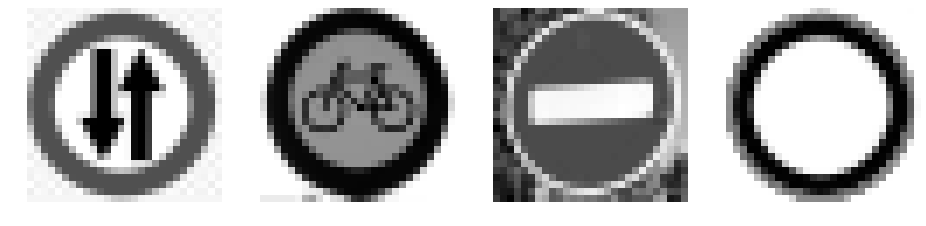

In [59]:
random_index = np.random.choice(100, 4)
rand_data = external_data.loc[random_index,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [60]:
external_data.head()

,image_path,shape_label,label
0,newdata/external_traffic_signs_data/hex/stop/h...,hex,stop
1,newdata/external_traffic_signs_data/hex/stop/h...,hex,stop
2,newdata/external_traffic_signs_data/hex/stop/h...,hex,stop
3,newdata/external_traffic_signs_data/hex/stop/h...,hex,stop
4,newdata/external_traffic_signs_data/hex/stop/h...,hex,stop


In [61]:
external_data = shuffle(external_data)
external_data.shape

(136, 3)

In [62]:
print ("records with diamond shape is " , len(external_data[external_data['shape_label']=='diamond']))
print ("records with hex shape is " , len(external_data[external_data['shape_label']=='hex']))
print ("records with round shape is " , len(external_data[external_data['shape_label']=='round']))
print ("records with square shape is ",len(external_data[external_data['shape_label']=='square']))
print ("records with triange shape is ", len(external_data[external_data['shape_label']=='triangle']))

records with diamond shape is  6
records with hex shape is  12
records with round shape is  99
records with square shape is  13
records with triange shape is  6


In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

realdata_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


batch_size = 16

realdata_generator = realdata_datagen.flow_from_dataframe(
        dataframe=external_data,
        directory='./',
        x_col="image_path",
        y_col="shape_label",
        target_size=(28, 28),
        batch_size=batch_size,
        shuffle = False,
        class_mode='categorical')

Found 136 validated image filenames belonging to 5 classes.


# Model_cnn_2L_v3

In [64]:
from sklearn import metrics

predictions = model_cnn_2L_v3.predict_generator(realdata_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

predictedLabels = np.asarray(predictedLabels)

true_classes = realdata_generator.classes
class_labels = list(realdata_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
cm = confusion_matrix(true_classes, predictedLabels)
print(cm)

Prediction shape is (136, 5)
              precision    recall  f1-score   support

     diamond       0.57      0.67      0.62         6
         hex       1.00      0.42      0.59        12
       round       0.91      0.92      0.91        99
      square       0.69      0.85      0.76        13
    triangle       0.75      1.00      0.86         6

   micro avg       0.86      0.86      0.86       136
   macro avg       0.78      0.77      0.75       136
weighted avg       0.87      0.86      0.86       136

[[ 4  0  2  0  0]
 [ 0  5  7  0  0]
 [ 3  0 91  5  0]
 [ 0  0  0 11  2]
 [ 0  0  0  0  6]]
